In [15]:
%%capture 
%run config.ipynb

In [2]:
from dataclasses import dataclass
import numpy as np
from xml.etree import ElementTree
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
from pprint import pprint

In [3]:
# Define Ink class
@dataclass
class Ink:
  """Represents a single ink, as read from an InkML file."""
  # Every stroke in the ink.
  # Each stroke array has shape (3, number of points), where the first
  # dimensions are (x, y, timestamp), in that order.
  strokes: list[np.ndarray]
  # Metadata present in the InkML.
  annotations: dict[str, str]

In [4]:
# Define function that reads inkml file, and outputs Ink object
def read_inkml_file(filename: str) -> Ink:
  """Simple reader for MathWriting's InkML files."""
  with open(filename, "r") as f:
    root = ElementTree.fromstring(f.read())

  strokes = []
  annotations = {}

  for element in root:
    tag_name = element.tag.removeprefix('{http://www.w3.org/2003/InkML}')
    if tag_name == 'annotation':
      annotations[element.attrib.get('type')] = element.text

    elif tag_name == 'trace':
      points = element.text.split(',')
      stroke_x, stroke_y, stroke_t = [], [], []
      for point in points:
        x, y, t = point.split(' ')
        stroke_x.append(float(x))
        stroke_y.append(float(y))
        stroke_t.append(float(t))
      strokes.append(np.array((stroke_x, stroke_y, stroke_t)))

  return Ink(strokes=strokes, annotations=annotations)

In [5]:
# display inkml file into image
def display_ink(
    ink: Ink,
    *,
    figsize: tuple[int, int]=(15, 10),
    linewidth: int=2,
    color=None):
  """Simple display for a single ink."""
  plt.figure(figsize=figsize)
  for stroke in ink.strokes:
    plt.plot(stroke[0], stroke[1], linewidth=linewidth, color=color)
    plt.title(
        f"{ink.annotations.get('sampleId', '')} -- "
        f"{ink.annotations.get('splitTagOriginal', '')} -- "
        f"{ink.annotations.get('normalizedLabel', ink.annotations['label'])}"
    )
  plt.gca().invert_yaxis()
  plt.gca().axis('equal')

{'inkCreationMethod': 'human',
 'label': '|S| \\le \\binom{n}{\\lfloor n/2\\rfloor}',
 'normalizedLabel': '|S|\\le(\\begin{matrix}n\\\\ \\lfloor '
                    'n/2\\rfloor\\end{matrix})',
 'sampleId': '01fdfab60060594b',
 'splitTagOriginal': 'train'}


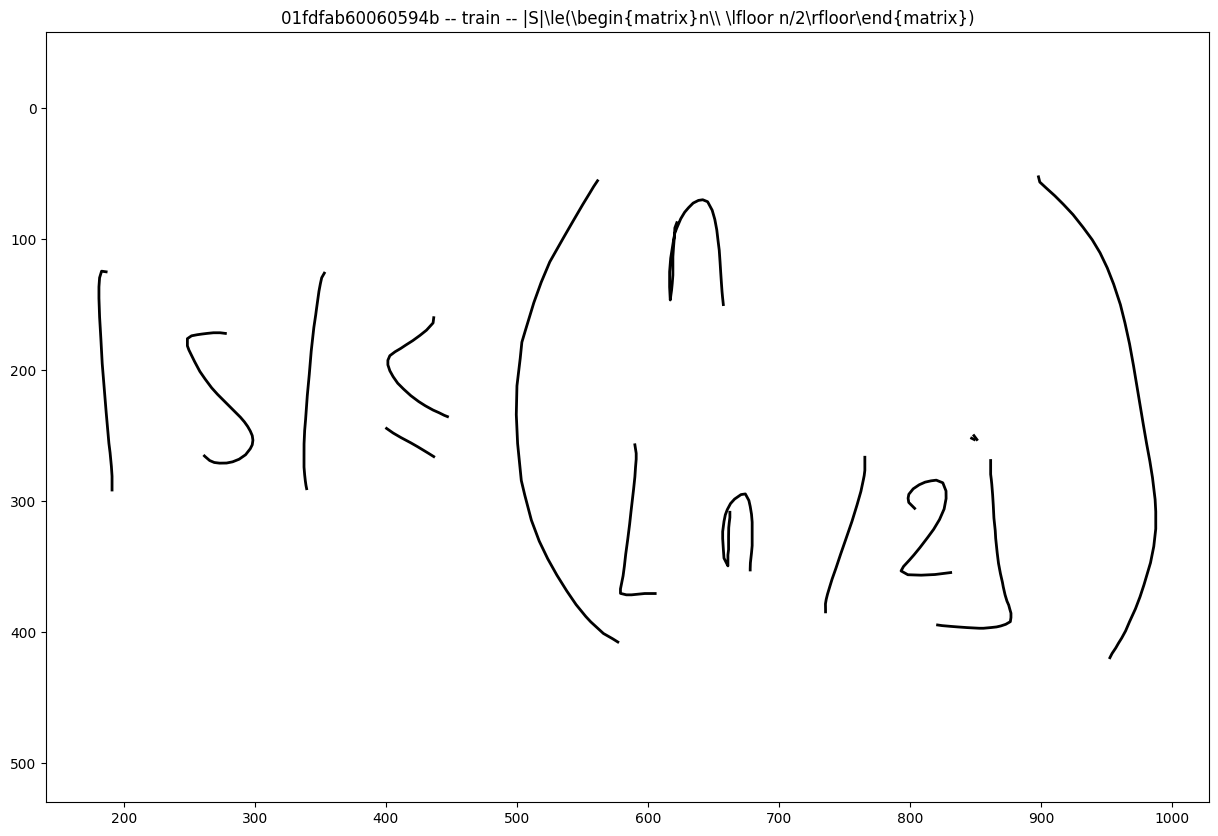

In [6]:
# TEST PURPOSE
test_inkml_file_path = data_dir / "mathwriting-2024-excerpt" / "train" / "01fdfab60060594b.inkml"
test_ink = read_inkml_file(test_inkml_file_path)
pprint(test_ink.annotations)
# pprint(test_ink.strokes)
display_ink(test_ink, color='black')


In [24]:
def get_ink_sequence_token(ink: Ink, timedelta_: int):
    """
    Apply 
    1. Time sampling
    2. Scale normalization
    3. Coordinate representation
    """

    max_x, min_x = None, None 
    max_y, min_y = None, None 
    
    # Time sampling
    time_sampled_strokes = []
    
    # time delta between two adjacent points should be at least timedelta_
    for stroke in ink.strokes: 
        stroke_x, stroke_y, stroke_t = stroke[0], stroke[1], stroke[2]

        prev_t = stroke_t[0] - (float(timedelta_) * 2)
        sampled_stroke_x, sampled_stroke_y= [], []
        
        for x, y, t in zip(stroke_x, stroke_y, stroke_t):
            if max_x == None or min_x == None or max_y == None or min_y == None:
                max_x = x 
                min_x = x 
                max_y = y 
                min_y = y 
                
            if t - prev_t >= timedelta_:
                prev_t = t 
                # add this point to strokes 
                sampled_stroke_x.append(x)
                sampled_stroke_y.append(y)
                # update max_x, min_x, max_y, min_y if needed 
                if x > max_x:
                    max_x = x 
                if x < min_x:
                    min_x = x 
                if y > max_y:
                    max_y = y 
                if y < min_y:
                    min_y = y 
                
        time_sampled_strokes.append(np.array((sampled_stroke_x, sampled_stroke_y)))

    # Scale normalization
    scale_normalized_strokes = []
    
    # print(f'max_x: {max_x}, min_x: {min_x}, max_y: {max_y}, min_y: {min_y}')

    # for every point's x value, (x - min_x) * (IMG_SIZE - 2 * PADDING) / (max_x - min_x) + PADDING
    # for every point's y value, (y - min_y) * IMG_SIZE / (max_y - min_y)
    for stroke in time_sampled_strokes:
        stroke_x, stroke_y = stroke[0], stroke[1]

        normalized_stroke_x, normalized_stroke_y = [], []
        for x, y in zip(stroke_x, stroke_y):
            normalized_stroke_x.append(((x - min_x) * (IMG_SIZE - 2 * PADDING) / (max_x - min_x)) + PADDING)
            normalized_stroke_y.append(((y - min_y) * (IMG_SIZE - 2 * PADDING) / (max_y - min_y)) + PADDING)

        scale_normalized_strokes.append(np.array((normalized_stroke_x, normalized_stroke_y)))

    # pprint(scale_normalized_strokes)

    # Discretization
    # Converting all float coordinates into int 
    discretized_strokes = []

    for stroke in scale_normalized_strokes:
        stroke_x, stroke_y = stroke[0], stroke[1]

        discretized_stroke_x, discretized_stroke_y = [], []

        for x, y in zip(stroke_x, stroke_y):
            discretized_stroke_x.append(round(x))
            discretized_stroke_y.append(round(y))
            
        discretized_strokes.append(np.array((discretized_stroke_x, discretized_stroke_y)))

    # pprint(discretized_strokes)

    # Coordinate representation
    relative_position_strokes = []

    for stroke in discretized_strokes:
        stroke_x, stroke_y = stroke[0], stroke[1]

        relative_stroke_x, relative_stroke_y = [], []

        prev_x, prev_y = None, None

        for x, y in zip(stroke_x, stroke_y):
            if prev_x == None and prev_y == None:
                relative_stroke_x.append(x)
                relative_stroke_y.append(y)
                prev_x = x 
                prev_y = y 
            else:
                relative_stroke_x.append(x - prev_x)
                relative_stroke_y.append(y - prev_y)
        
        relative_position_strokes.append(np.array((relative_stroke_x, relative_stroke_y)))
    # pprint(relative_position_strokes)

    # return string of sequences of points 
    # new stroke starts with seperator <stroke>
    result = ""
    for stroke in relative_position_strokes:
        stroke_x, stroke_y = stroke[0], stroke[1]
        result += "<stroke> "

        for x, y in zip(stroke_x, stroke_y):
            result += f'{x} {y} '

    # pprint(result)
    return result
        
        
            
            
        
            
            
    
            
    
    
    
    

        
            
    

In [25]:
# TEST PURPOSE
test_inkml_file_path = data_dir / "mathwriting-2024-excerpt" / "train" / "01fdfab60060594b.inkml"
test_ink = read_inkml_file(test_inkml_file_path)
get_ink_sequence_token(test_ink, TIME_SAMPLING_DELTA)

<class 'str'>
